# Vision Transformer (ViT) Model Training with Improvements

This notebook trains a Vision Transformer model for gastric cancer histopathology classification with:
- **Stain Normalization** (Macenko method)
- **Focal Loss** with class weighting
- **20 Epochs** (10 Phase 1 + 10 Phase 2)
- **Local Dataset** execution


## 1. Environment Setup

Install required packages for local execution.


In [16]:
# Install required packages
import subprocess
import sys
import platform

def install_package(package):
    """Install package if not already installed"""
    try:
        __import__(package)
        print(f"✓ {package} already installed")
        return True
    except ImportError:
        print(f"Installing {package}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package], 
                                 stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            print(f"✓ {package} installed successfully")
            return True
        except subprocess.CalledProcessError:
            print(f"⚠ Failed to install {package}")
            return False

def check_cuda_version():
    """Check CUDA version using nvidia-smi"""
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=driver_version', '--format=csv,noheader'], 
                              capture_output=True, text=True, timeout=5)
        if result.returncode == 0:
            # Try to get CUDA version from nvidia-smi
            result2 = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=5)
            if 'CUDA Version:' in result2.stdout:
                for line in result2.stdout.split('\n'):
                    if 'CUDA Version:' in line:
                        cuda_ver = line.split('CUDA Version:')[1].strip().split()[0]
                        return cuda_ver
        return None
    except:
        return None

# ============================================================================
# STEP 1: Check and Install PyTorch with CUDA
# ============================================================================
print("="*60)
print("STEP 1: PyTorch and CUDA Setup")
print("="*60)

torch_installed = False
cuda_available = False
pytorch_just_installed = False  # Track if we just installed PyTorch

# Check if PyTorch is already installed
try:
    import torch
    torch_installed = True
    print(f"✓ PyTorch version: {torch.__version__}")
    
    if torch.cuda.is_available():
        cuda_available = True
        print(f"✓ CUDA is available! GPU will be used for training.")
        print(f"  GPU: {torch.cuda.get_device_name(0)}")
        print(f"  CUDA Version: {torch.version.cuda}")
    else:
        print("⚠ PyTorch installed but CUDA not available.")
        print("  This usually means PyTorch was installed without CUDA support.")
        
except ImportError:
    print("⚠ PyTorch not found. Will install PyTorch with CUDA support.")

# If PyTorch not installed or CUDA not available, install PyTorch with CUDA
if not torch_installed or not cuda_available:
    print("\n" + "-"*60)
    print("Installing PyTorch with CUDA support...")
    print("-"*60)
    
    # Check CUDA version from system
    cuda_version = check_cuda_version()
    
    if cuda_version:
        print(f"Detected CUDA version: {cuda_version}")
        # Map CUDA version to PyTorch CUDA version
        if cuda_version.startswith('12.'):
            pytorch_cuda = 'cu121'
            print(f"Installing PyTorch with CUDA 12.1 support...")
        elif cuda_version.startswith('11.8'):
            pytorch_cuda = 'cu118'
            print(f"Installing PyTorch with CUDA 11.8 support...")
        elif cuda_version.startswith('11.'):
            pytorch_cuda = 'cu118'  # Most common
            print(f"Installing PyTorch with CUDA 11.8 support...")
        else:
            pytorch_cuda = 'cu118'  # Default to most common
            print(f"Installing PyTorch with CUDA 11.8 support (default)...")
    else:
        # Default to CUDA 11.8 (most compatible)
        pytorch_cuda = 'cu118'
        print("Could not detect CUDA version. Installing PyTorch with CUDA 11.8 (default)...")
        print("If you have a different CUDA version, you may need to reinstall manually.")
    
    # Install PyTorch with CUDA
    try:
        print(f"\nInstalling PyTorch, torchvision, and torchaudio with {pytorch_cuda}...")
        print("This may take a few minutes...")
        
        install_cmd = [
            sys.executable, "-m", "pip", "install", 
            "torch", "torchvision", "torchaudio",
            "--index-url", f"https://download.pytorch.org/whl/{pytorch_cuda}"
        ]
        
        subprocess.check_call(install_cmd)
        print("✓ PyTorch with CUDA installed successfully!")
        pytorch_just_installed = True
        
        # Note: On Windows, reloading torch can cause DLL errors
        # User needs to restart kernel to use the new PyTorch installation
        print("\n" + "!"*60)
        print("IMPORTANT: Kernel Restart Required")
        print("!"*60)
        print("PyTorch with CUDA has been installed, but you MUST restart the kernel")
        print("for the changes to take effect.")
        print("\nTo restart kernel:")
        print("  - Jupyter: Kernel → Restart Kernel")
        print("  - VS Code: Click 'Restart' button in notebook toolbar")
        print("  - Or use: Kernel → Restart & Clear Output")
        print("\nAfter restarting, run this cell again to verify CUDA is available.")
        
        # Don't try to reload torch - it causes DLL errors on Windows
        # Just set flag that installation was successful
        cuda_available = False  # Will be True after kernel restart
    except subprocess.CalledProcessError as e:
        print(f"⚠ Failed to install PyTorch with CUDA: {e}")
        print("\nManual installation:")
        print(f"  pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/{pytorch_cuda}")
        print("\nOr visit: https://pytorch.org/get-started/locally/")
    except Exception as e:
        print(f"⚠ Error during installation: {e}")
        print("\nYou may need to install PyTorch manually.")
        print("Visit: https://pytorch.org/get-started/locally/")

# ============================================================================
# STEP 2: Install Other Required Packages
# ============================================================================
print("\n" + "="*60)
print("STEP 2: Installing Other Required Packages")
print("="*60)

packages_to_install = [
    "timm",
    "transformers",
    "torchstain",  # For stain normalization
    "scikit-learn",
    "matplotlib",
    "seaborn",
    "numpy",
    "Pillow"
]

for package in packages_to_install:
    install_package(package)

# Final verification
print("\n" + "="*60)
print("INSTALLATION SUMMARY")
print("="*60)
try:
    # Try to import torch (may fail if just installed and kernel not restarted)
    import torch
    print(f"✓ PyTorch: {torch.__version__}")
    try:
        if torch.cuda.is_available():
            print(f"✓ CUDA: Available")
            print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
            print(f"✓ CUDA Version: {torch.version.cuda}")
            print("\n🚀 Ready for GPU training!")
        else:
            print("⚠ CUDA: Not available (will use CPU)")
            print("⚠ Training will be slow on CPU")
            if not torch_installed or not cuda_available:
                print("\n💡 If you just installed PyTorch with CUDA:")
                print("   → RESTART THE KERNEL and run this cell again")
    except Exception as e:
        print(f"⚠ Error checking CUDA: {e}")
        print("   This may be normal if PyTorch was just installed.")
        print("   → RESTART THE KERNEL and run this cell again")
except ImportError:
    print("⚠ PyTorch not found or not yet loaded")
    if not torch_installed:
        print("   PyTorch installation may have failed or kernel needs restart")
    else:
        print("   → RESTART THE KERNEL and run this cell again")
except Exception as e:
    print(f"⚠ PyTorch verification failed: {e}")
    print("   → If you just installed PyTorch, RESTART THE KERNEL")

print("\n✓ All packages installation completed!")
print("\n" + "="*60)
print("NEXT STEPS:")
print("="*60)
# Check if we just installed PyTorch (need kernel restart)
try:
    if pytorch_just_installed:
        print("⚠ RESTART KERNEL REQUIRED")
        print("1. RESTART THE KERNEL now (Kernel → Restart)")
        print("2. Run this cell again to verify CUDA")
        print("3. Continue with the rest of the notebook")
    elif not cuda_available:
        print("1. CUDA not available - check if PyTorch has CUDA support")
        print("2. If needed, restart kernel and run this cell again")
    else:
        print("1. Continue to the next cell")
        print("2. GPU will be automatically used if available")
except NameError:
    # Variables not defined (shouldn't happen, but handle gracefully)
    print("1. Continue to the next cell")
    print("2. If you see CUDA errors, restart kernel and run this cell again")


STEP 1: PyTorch and CUDA Setup
✓ PyTorch version: 2.5.1+cu121
✓ CUDA is available! GPU will be used for training.
  GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
  CUDA Version: 12.1

STEP 2: Installing Other Required Packages
✓ timm already installed
✓ transformers already installed
✓ torchstain already installed
Installing scikit-learn...
✓ scikit-learn installed successfully
✓ matplotlib already installed
✓ seaborn already installed
✓ numpy already installed
Installing Pillow...
✓ Pillow installed successfully

INSTALLATION SUMMARY
✓ PyTorch: 2.5.1+cu121
✓ CUDA: Available
✓ GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
✓ CUDA Version: 12.1

🚀 Ready for GPU training!

✓ All packages installation completed!

NEXT STEPS:
1. Continue to the next cell
2. GPU will be automatically used if available


## 2. Import Libraries and Setup Paths


In [17]:
import os
import sys
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, f1_score, matthews_corrcoef
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import json
import timm
from pathlib import Path

# Add current directory to path to import shared utilities
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)

try:
    from shared_utilities import (
        set_seeds, get_device, load_dataset_paths, create_splits,
        HistopathologyDataset, train_one_epoch, validate, evaluate_model,
        plot_confusion_matrix, plot_tsne, CLASSES, NUM_CLASSES, CLASS_TO_IDX, IDX_TO_CLASS
    )
except ImportError as e:
    print(f"Error importing shared_utilities: {e}")
    print(f"Current directory: {current_dir}")
    print(f"Files in current directory: {os.listdir(current_dir)}")
    raise

# Local dataset path
DATASET_PATH = os.path.join("Dataset", "HMU-GC-HE-30K", "all_image")

# Verify dataset path exists
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}. Please check the path.")

print(f"✓ Dataset path: {DATASET_PATH}")
print(f"✓ Classes: {CLASSES}")
print(f"✓ Number of classes: {NUM_CLASSES}")


✓ Dataset path: Dataset\HMU-GC-HE-30K\all_image
✓ Classes: ['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']
✓ Number of classes: 8


## 3. Improvements Implementation

Import and define improvements: Stain Normalization, Focal Loss, and Class Weighting.


In [18]:
# ============================================================================
# STAIN NORMALIZATION
# ============================================================================

def get_stain_normalized_transform():
    """
    Get transform with stain normalization using Macenko method
    """
    try:
        from torchstain import MacenkoNormalizer
        
        # Create normalizer
        normalizer = MacenkoNormalizer(backend='torch')
        
        def normalize_stain(image):
            """Normalize H&E stain"""
            # Convert PIL to tensor
            if isinstance(image, Image.Image):
                image_tensor = transforms.ToTensor()(image)
            else:
                image_tensor = image
            
            # Normalize (expects [C, H, W] format)
            if len(image_tensor.shape) == 3:
                image_tensor = image_tensor.unsqueeze(0)
            
            normalized = normalizer.normalize(image_tensor)
            
            # Convert back to PIL if needed
            if isinstance(image, Image.Image):
                normalized = normalized.squeeze(0)
                normalized = transforms.ToPILImage()(normalized)
            
            return normalized
        
        # Create transform pipeline
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.Lambda(normalize_stain),  # Stain normalization
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
        val_test_transform = transforms.Compose([
            transforms.Lambda(normalize_stain),  # Also normalize val/test
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
        print("✓ Stain normalization enabled (Macenko method)")
        return train_transform, val_test_transform
    
    except ImportError:
        print("⚠ Warning: torchstain not installed. Using standard transforms.")
        print("  Install with: pip install torchstain")
        # Fallback to standard transforms
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
        val_test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        return train_transform, val_test_transform

# ============================================================================
# FOCAL LOSS
# ============================================================================

class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance and hard examples
    FL(p_t) = -α(1-p_t)^γ * log(p_t)
    """
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ============================================================================
# CLASS-SPECIFIC LOSS WEIGHTING
# ============================================================================

def get_class_weights_for_confusion(y_train, confusion_pairs=None):
    """
    Create class weights that penalize specific confusions
    """
    # Base weights (inverse frequency)
    base_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    
    # Increase weights for classes involved in critical confusions
    if confusion_pairs:
        for class1_idx, class2_idx in confusion_pairs:
            base_weights[class1_idx] *= 1.5
            base_weights[class2_idx] *= 1.5
    
    return torch.FloatTensor(base_weights)

class WeightedFocalLoss(nn.Module):
    """
    Focal Loss with class weights
    Combines benefits of both approaches
    """
    def __init__(self, class_weights, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.register_buffer('class_weights', class_weights)
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(
            inputs, targets,
            weight=self.class_weights,
            reduction='none'
        )
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

print("✓ Improvements loaded: Stain Normalization, Focal Loss, Class Weighting")


✓ Improvements loaded: Stain Normalization, Focal Loss, Class Weighting


In [19]:
!nvidia-smi


Sat Jan  3 15:26:35 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.97                 Driver Version: 555.97         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8              3W /   50W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 4. ViT Model Definition


In [20]:
class UNIClassifier(nn.Module):
    """
    Vision Transformer (ViT) Classifier
    Uses ViT-Base from timm as backbone
    """
    def __init__(self, num_classes=8, dropout=0.5, use_uni=False):
        super().__init__()
        
        self.use_hf_model = False
        
        # Try to load UNI if requested and available
        if use_uni:
            try:
                # Try Hugging Face UNI
                from transformers import AutoModel
                self.backbone = AutoModel.from_pretrained('microsoft/uni')
                if hasattr(self.backbone, 'config'):
                    hidden_size = self.backbone.config.hidden_size
                    self.use_hf_model = True
                    print("✓ Loaded UNI from Hugging Face")
                else:
                    raise ValueError("UNI model structure not recognized")
            except Exception as e:
                print(f"Could not load UNI from Hugging Face: {e}")
                print("Falling back to ViT-Base")
                use_uni = False
        
        # Default: Use ViT-Base from timm
        if not self.use_hf_model:
            try:
                self.backbone = timm.create_model('uni_vit_base', pretrained=True)
                hidden_size = self.backbone.num_features
                print("✓ Loaded UNI from timm")
            except:
                # Fallback to standard ViT-Base
                self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True)
                hidden_size = self.backbone.num_features
                print("✓ Loaded ViT-Base from timm")
        
        # Replace classifier head
        if hasattr(self.backbone, 'head'):
            self.backbone.head = nn.Identity()
            self.classifier = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(hidden_size, num_classes)
            )
        elif hasattr(self.backbone, 'classifier'):
            self.backbone.classifier = nn.Identity()
            self.classifier = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(hidden_size, num_classes)
            )
        else:
            self.classifier = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(hidden_size, num_classes)
            )
    
    def forward(self, x):
        """Forward pass for ViT model"""
        if hasattr(self.backbone, 'forward_features'):
            features = self.backbone.forward_features(x)
        else:
            features = self.backbone(x)
        
        # Handle tuple output
        if isinstance(features, tuple):
            features = features[-1]
        
        # ViT outputs: [batch, num_patches+1, hidden_dim]
        # Take CLS token (first token)
        if len(features.shape) == 3:
            features = features[:, 0]  # CLS token
        elif len(features.shape) == 4:
            features = features.mean(dim=[2, 3])
        
        return self.classifier(features)
    
    def freeze_backbone(self):
        """Freeze backbone, train only classifier"""
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.classifier.parameters():
            param.requires_grad = True
    
    def unfreeze_top_layers(self, num_layers=2):
        """Unfreeze top transformer layers for fine-tuning"""
        for param in self.classifier.parameters():
            param.requires_grad = True
        
        # Unfreeze last N transformer blocks
        if hasattr(self.backbone, 'blocks'):
            blocks = self.backbone.blocks
            for block in blocks[-num_layers:]:
                for param in block.parameters():
                    param.requires_grad = True
        elif hasattr(self.backbone, 'encoder'):
            encoder_layers = self.backbone.encoder.layer
            for layer in encoder_layers[-num_layers:]:
                for param in layer.parameters():
                    param.requires_grad = True

print("✓ ViT Model class defined")


✓ ViT Model class defined


## 5. Configuration and Hyperparameters

Set training parameters: 20 epochs total (10 Phase 1 + 10 Phase 2)


In [21]:
# Training hyperparameters
RANDOM_SEED = 42
BATCH_SIZE = 32
NUM_EPOCHS_PHASE1 = 10  # Phase 1: Train classifier head
NUM_EPOCHS_PHASE2 = 10  # Phase 2: Fine-tune transformer layers
EARLY_STOP_PATIENCE = 5

# Set seeds for reproducibility
set_seeds(RANDOM_SEED)

# Get device
device = get_device()

# GPU Verification
print("\n" + "="*60)
print("GPU VERIFICATION")
print("="*60)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"✓ GPU Detected: {torch.cuda.get_device_name(0)}")
    print(f"✓ CUDA Version: {torch.version.cuda}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"✓ Device: {device}")
    print("\n🚀 Training will use GPU (much faster than CPU!)")
else:
    print("⚠ GPU NOT DETECTED - Training will use CPU (very slow!)")
    print("\nTo use GPU, you need:")
    print("1. Install PyTorch with CUDA support:")
    print("   Visit: https://pytorch.org/get-started/locally/")
    print("   Select your CUDA version and install the appropriate PyTorch")
    print("2. Ensure NVIDIA drivers are installed")
    print("3. Verify CUDA is accessible: nvidia-smi")

print("\n" + "="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print(f"✓ Random seed: {RANDOM_SEED}")
print(f"✓ Batch size: {BATCH_SIZE}")
print(f"✓ Phase 1 epochs: {NUM_EPOCHS_PHASE1}")
print(f"✓ Phase 2 epochs: {NUM_EPOCHS_PHASE2}")
print(f"✓ Early stopping patience: {EARLY_STOP_PATIENCE}")


✓ Using CUDA: NVIDIA GeForce RTX 3050 6GB Laptop GPU

GPU VERIFICATION
PyTorch version: 2.5.1+cu121
CUDA available: True
✓ GPU Detected: NVIDIA GeForce RTX 3050 6GB Laptop GPU
✓ CUDA Version: 12.1
✓ GPU Memory: 6.00 GB
✓ Device: cuda

🚀 Training will use GPU (much faster than CPU!)

TRAINING CONFIGURATION
✓ Random seed: 42
✓ Batch size: 32
✓ Phase 1 epochs: 10
✓ Phase 2 epochs: 10
✓ Early stopping patience: 5


## 6. Load Dataset and Create Splits


In [22]:
# Load dataset paths
image_paths, labels = load_dataset_paths(dataset_root=DATASET_PATH)

# Create train/val/test splits
(X_train, y_train), (X_val, y_val), (X_test, y_test) = create_splits(
    image_paths, labels, test_size=0.15, val_size=0.15, seed=RANDOM_SEED
)

print(f"\n✓ Dataset loaded and split successfully")
print(f"  Train: {len(X_train)} samples")
print(f"  Val: {len(X_val)} samples")
print(f"  Test: {len(X_test)} samples")


Loaded 31096 images from 8 classes
Train: 21766 (70.0%)
Val: 4665 (15.0%)
Test: 4665 (15.0%)

✓ Dataset loaded and split successfully
  Train: 21766 samples
  Val: 4665 samples
  Test: 4665 samples


## 7. Setup Data Loaders with Stain Normalization


In [23]:
# Get transforms with stain normalization
train_transform, val_test_transform = get_stain_normalized_transform()

# Create datasets
train_dataset = HistopathologyDataset(X_train, y_train, transform=train_transform)
val_dataset = HistopathologyDataset(X_val, y_val, transform=val_test_transform)
test_dataset = HistopathologyDataset(X_test, y_test, transform=val_test_transform)

# Create data loaders (use num_workers=0 for Windows compatibility)
num_workers = 0 if sys.platform == 'win32' else 2

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=num_workers
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, 
    shuffle=False, num_workers=num_workers
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, 
    shuffle=False, num_workers=num_workers
)

print(f"✓ Data loaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


⚠ Warning: torchstain not installed. Using standard transforms.
  Install with: pip install torchstain
✓ Data loaders created
  Train batches: 681
  Val batches: 146
  Test batches: 146


## 8. Setup Loss Function with Class Weighting

Use Weighted Focal Loss to address class imbalance and critical confusions.


In [24]:
# Define critical confusion pairs to penalize more
# Based on common histopathology confusions
confusion_pairs = [
    (CLASS_TO_IDX['NOR'], CLASS_TO_IDX['TUM']),  # Normal vs Tumor
    (CLASS_TO_IDX['MUC'], CLASS_TO_IDX['ADI']),  # Mucus vs Adipose
    (CLASS_TO_IDX['DEB'], CLASS_TO_IDX['STR']),  # Debris vs Stroma
]

# Get class weights
class_weights = get_class_weights_for_confusion(y_train, confusion_pairs)

# Create Weighted Focal Loss
criterion = WeightedFocalLoss(class_weights, alpha=0.25, gamma=2.0).to(device)

print("✓ Loss function: Weighted Focal Loss")
print(f"  Class weights: {dict(zip(CLASSES, class_weights.cpu().numpy()))}")
print(f"  Confusion pairs penalized: {[(CLASSES[i], CLASSES[j]) for i, j in confusion_pairs]}")


✓ Loss function: Weighted Focal Loss
  Class weights: {'ADI': np.float32(1.4998622), 'DEB': np.float32(1.4998622), 'LYM': np.float32(0.99990815), 'MUC': np.float32(1.4998622), 'MUS': np.float32(0.99990815), 'NOR': np.float32(1.4998622), 'STR': np.float32(1.5004137), 'TUM': np.float32(1.5004137)}
  Confusion pairs penalized: [('NOR', 'TUM'), ('MUC', 'ADI'), ('DEB', 'STR')]


## 9. Initialize Model


In [25]:
# Initialize ViT model
model = UNIClassifier(num_classes=NUM_CLASSES, dropout=0.5, use_uni=False).to(device)
print("✓ Model initialized and moved to device")

# Freeze backbone for Phase 1
model.freeze_backbone()
print("✓ Backbone frozen (Phase 1: training classifier only)")


✓ Loaded ViT-Base from timm
✓ Model initialized and moved to device
✓ Backbone frozen (Phase 1: training classifier only)


## 10. Phase 1: Train Classifier Head

Train only the classifier head while the backbone is frozen.


In [26]:
# Phase 1: Train classifier head
optimizer_phase1 = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3, weight_decay=1e-4
)

print("="*60)
print("PHASE 1: Training Classifier Head (ViT Backbone Frozen)")
print("="*60)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(NUM_EPOCHS_PHASE1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer_phase1, device
    )
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS_PHASE1}]")
    print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
    print(f"  Val: Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'vit_phase1_best.pt')
        print(f"  ✓ Best model saved")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"  Early stopping")
            break

print("\n✓ Phase 1 completed!")


PHASE 1: Training Classifier Head (ViT Backbone Frozen)
Epoch [1/10]
  Train: Loss=0.3773, Acc=48.30%
  Val: Loss=0.3152, Acc=55.13%
  ✓ Best model saved
Epoch [2/10]
  Train: Loss=0.3361, Acc=53.39%
  Val: Loss=0.2978, Acc=55.20%
  ✓ Best model saved
Epoch [3/10]
  Train: Loss=0.3357, Acc=53.43%
  Val: Loss=0.2932, Acc=56.68%
  ✓ Best model saved
Epoch [4/10]
  Train: Loss=0.3346, Acc=53.38%
  Val: Loss=0.2849, Acc=57.21%
  ✓ Best model saved
Epoch [5/10]
  Train: Loss=0.3389, Acc=53.07%
  Val: Loss=0.2747, Acc=59.01%
  ✓ Best model saved
Epoch [6/10]
  Train: Loss=0.3371, Acc=53.36%
  Val: Loss=0.2934, Acc=56.76%
Epoch [7/10]
  Train: Loss=0.3346, Acc=53.54%
  Val: Loss=0.3043, Acc=55.78%
Epoch [8/10]
  Train: Loss=0.3322, Acc=53.95%
  Val: Loss=0.2740, Acc=59.14%
  ✓ Best model saved
Epoch [9/10]
  Train: Loss=0.3356, Acc=53.50%
  Val: Loss=0.2745, Acc=58.44%
Epoch [10/10]
  Train: Loss=0.3333, Acc=53.74%
  Val: Loss=0.3122, Acc=56.96%

✓ Phase 1 completed!


## 11. Phase 2: Fine-tune Transformer Layers

Unfreeze top transformer layers and fine-tune with lower learning rate.


In [27]:
# Load best model from Phase 1
model.load_state_dict(torch.load('vit_phase1_best.pt'))
model.unfreeze_top_layers(num_layers=2)

# Separate parameter groups for different learning rates
backbone_params = []
head_params = []
for name, param in model.named_parameters():
    if 'classifier' in name or 'head' in name:
        head_params.append(param)
    elif param.requires_grad:
        backbone_params.append(param)

optimizer_phase2 = optim.AdamW([
    {'params': head_params, 'lr': 1e-4},
    {'params': backbone_params, 'lr': 1e-5}  # Lower LR for pretrained transformer
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_phase2, mode='min', factor=0.5, patience=3
)

print("\n" + "="*60)
print("PHASE 2: Fine-tuning ViT Transformer Layers")
print("="*60)

best_val_loss_phase2 = float('inf')
patience_counter_phase2 = 0

for epoch in range(NUM_EPOCHS_PHASE2):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer_phase2, device
    )
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS_PHASE2}]")
    print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
    print(f"  Val: Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
    print(f"  LR: {optimizer_phase2.param_groups[0]['lr']:.2e}")
    
    if val_loss < best_val_loss_phase2:
        best_val_loss_phase2 = val_loss
        patience_counter_phase2 = 0
        torch.save(model.state_dict(), 'vit_final.pt')
        print(f"  ✓ Best model saved")
    else:
        patience_counter_phase2 += 1
        if patience_counter_phase2 >= EARLY_STOP_PATIENCE:
            print(f"  Early stopping")
            break

print("\n✓ Phase 2 completed!")


C:\Users\Kavinu\AppData\Local\Temp\ipykernel_6980\961859152.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vit_phase1_best.pt'))



PHASE 2: Fine-tuning ViT Transformer Layers
Epoch [1/10]
  Train: Loss=0.2856, Acc=57.11%
  Val: Loss=0.2566, Acc=60.13%
  LR: 1.00e-04
  ✓ Best model saved
Epoch [2/10]
  Train: Loss=0.2543, Acc=60.73%
  Val: Loss=0.2363, Acc=62.83%
  LR: 1.00e-04
  ✓ Best model saved
Epoch [3/10]
  Train: Loss=0.2384, Acc=62.44%
  Val: Loss=0.2291, Acc=63.75%
  LR: 1.00e-04
  ✓ Best model saved
Epoch [4/10]
  Train: Loss=0.2265, Acc=64.05%
  Val: Loss=0.2239, Acc=64.01%
  LR: 1.00e-04
  ✓ Best model saved
Epoch [5/10]
  Train: Loss=0.2177, Acc=65.20%
  Val: Loss=0.2184, Acc=64.16%
  LR: 1.00e-04
  ✓ Best model saved
Epoch [6/10]
  Train: Loss=0.2097, Acc=66.35%
  Val: Loss=0.2111, Acc=65.57%
  LR: 1.00e-04
  ✓ Best model saved
Epoch [7/10]
  Train: Loss=0.2021, Acc=66.87%
  Val: Loss=0.2075, Acc=65.36%
  LR: 1.00e-04
  ✓ Best model saved
Epoch [8/10]
  Train: Loss=0.1940, Acc=68.43%
  Val: Loss=0.2071, Acc=66.20%
  LR: 1.00e-04
  ✓ Best model saved
Epoch [9/10]
  Train: Loss=0.1863, Acc=68.82%
  Val

## 12. Final Evaluation on Test Set


In [28]:
# Load best model
model.load_state_dict(torch.load('vit_final.pt'))

# Evaluate on test set
results = evaluate_model(model, test_loader, criterion, device)

print("\n" + "="*60)
print("VIT-BASE FINAL RESULTS")
print("="*60)
print(f"Test Accuracy: {results['test_acc']:.2f}%")
print(f"Macro F1: {results['macro_f1']:.4f}")
print(f"Weighted F1: {results['weighted_f1']:.4f}")
print(f"MCC: {results['mcc']:.4f}")

print("\nPer-Class F1 Scores:")
for i, class_name in enumerate(CLASSES):
    print(f"  {class_name}: {results['per_class_f1'][i]:.4f}")

# Print detailed classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(
    results['labels'], results['predictions'],
    target_names=CLASSES,
    digits=4
))


C:\Users\Kavinu\AppData\Local\Temp\ipykernel_6980\1398910.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vit_final.pt'))



VIT-BASE FINAL RESULTS
Test Accuracy: 67.10%
Macro F1: 0.6714
Weighted F1: 0.6714
MCC: 0.6247

Per-Class F1 Scores:
  ADI: 0.7752
  DEB: 0.6381
  LYM: 0.8251
  MUC: 0.6264
  MUS: 0.6692
  NOR: 0.5358
  STR: 0.6532
  TUM: 0.6479

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         ADI     0.7785    0.7719    0.7752       583
         DEB     0.5851    0.7015    0.6381       583
         LYM     0.8506    0.8010    0.8251       583
         MUC     0.6393    0.6141    0.6264       583
         MUS     0.7643    0.5952    0.6692       583
         NOR     0.5610    0.5129    0.5358       583
         STR     0.5972    0.7209    0.6532       584
         TUM     0.6457    0.6501    0.6479       583

    accuracy                         0.6710      4665
   macro avg     0.6777    0.6709    0.6714      4665
weighted avg     0.6777    0.6710    0.6714      4665



## 13. Visualizations


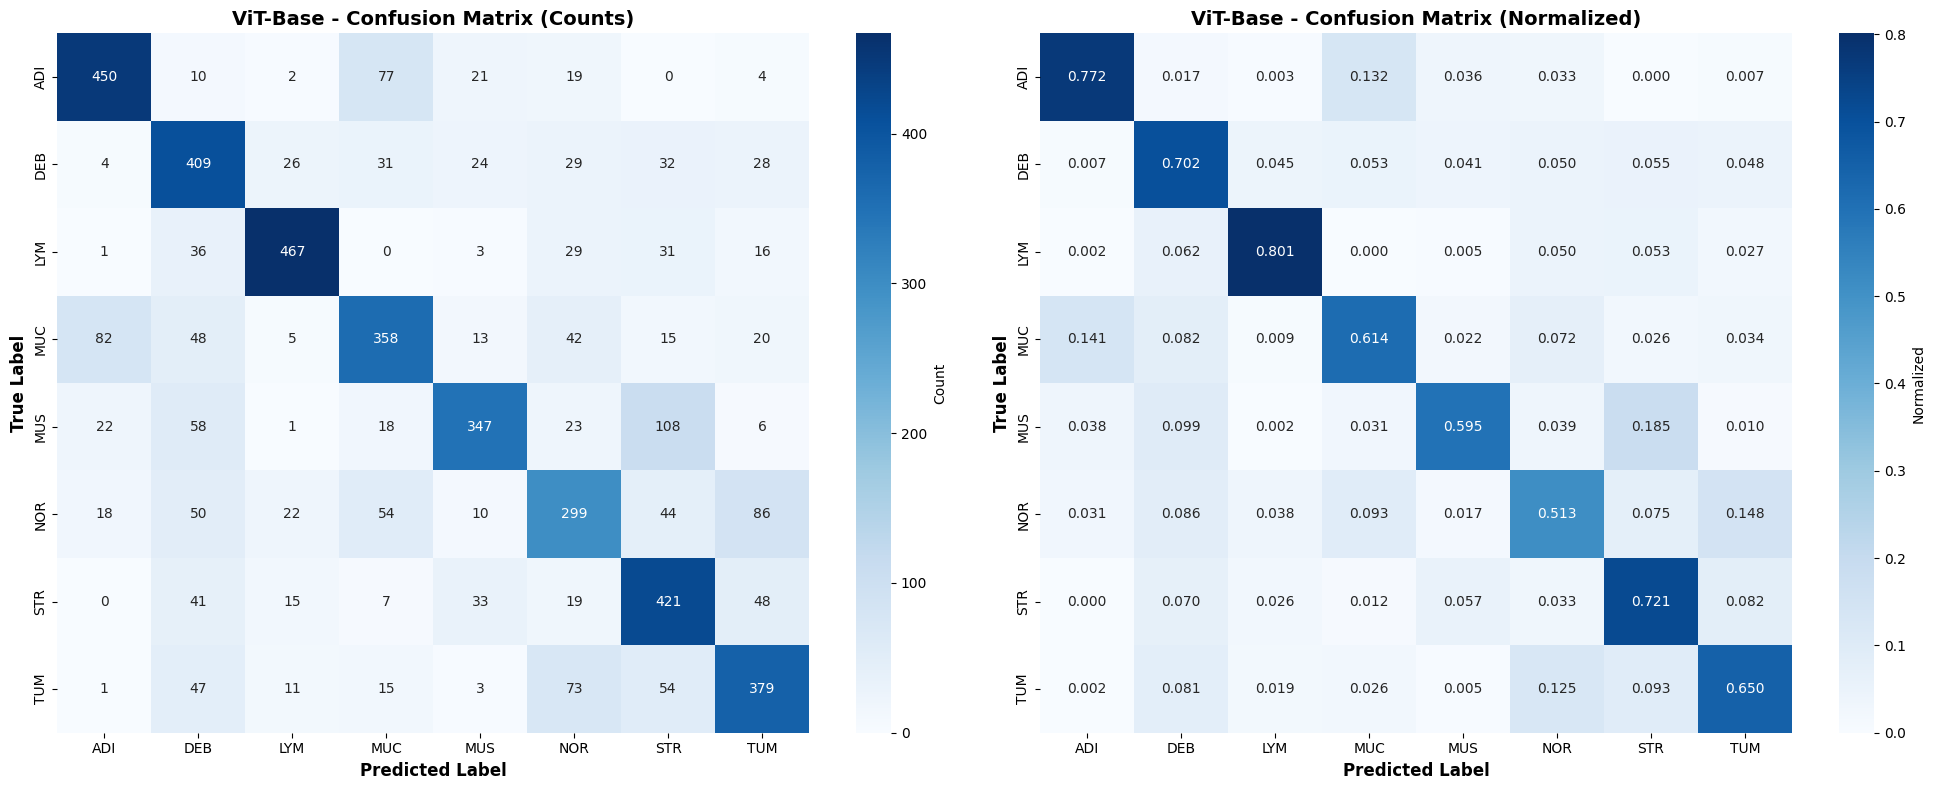

In [29]:
# Plot confusion matrix
plot_confusion_matrix(
    results['labels'], results['predictions'], 
    'ViT-Base', save_path='vit_cm.png'
)


In [30]:
# Extract and plot t-SNE (ViT embeddings)
try:
    model.eval()
    features_list = []
    labels_list = []
    count = 0
    max_samples = 500
    
    with torch.no_grad():
        for images, labels in test_loader:
            if count >= max_samples:
                break
            images = images.to(device)
            
            # Extract features before classifier
            if hasattr(model.backbone, 'forward_features'):
                feat = model.backbone.forward_features(images)
            else:
                feat = model.backbone(images)
            
            # Handle tuple output
            if isinstance(feat, tuple):
                feat = feat[-1]
            
            # Take CLS token (first token) for ViT
            if len(feat.shape) == 3:
                feat = feat[:, 0]  # [batch, hidden_dim]
            
            features_list.append(feat.cpu().numpy())
            labels_list.extend(labels.numpy())
            count += len(labels)
    
    if features_list:
        features_array = np.vstack(features_list)
        labels_array = np.array(labels_list[:len(features_array)])
        plot_tsne(features_array, labels_array, 'ViT-Base', save_path='vit_tsne.png')
        print("✓ t-SNE visualization saved")
except Exception as e:
    print(f"⚠ Could not extract features for t-SNE: {e}")
    print("  This is optional - training and evaluation completed successfully")


Computing t-SNE for ViT-Base...
⚠ Could not extract features for t-SNE: TSNE.__init__() got an unexpected keyword argument 'n_iter'
  This is optional - training and evaluation completed successfully


## 14. Save Model and Results

Save model and results to local disk and Google Drive (if in Colab).


In [31]:
# Use shared utility function to save model and results
# This will save to both local disk and Google Drive (if in Colab)
from shared_utilities import save_model_and_results

# Save model and results using utility function
# This automatically handles both local and Google Drive saving
try:
    model_path, results_path = save_model_and_results(
        model, results, 'vit', save_to_drive=True
    )
    print(f"\n✓ Model saved: {model_path}")
    print(f"✓ Results saved: {results_path}")
except Exception as e:
    print(f"⚠ Error using utility function: {e}")
    print("  Saving locally only...")
    
    # Fallback: Save locally only
    model_path = 'vit_final.pt'
    torch.save(model.state_dict(), model_path)
    print(f"✓ Model saved locally: {model_path}")
    
    results_path = 'vit_results.json'
    with open(results_path, 'w') as f:
        json.dump({
            'test_acc': float(results['test_acc']),
            'macro_f1': float(results['macro_f1']),
            'weighted_f1': float(results['weighted_f1']),
            'mcc': float(results['mcc']),
            'per_class_f1': results['per_class_f1'].tolist(),
            'history': {
                'train_loss': [float(x) for x in history['train_loss']],
                'train_acc': [float(x) for x in history['train_acc']],
                'val_loss': [float(x) for x in history['val_loss']],
                'val_acc': [float(x) for x in history['val_acc']]
            }
        }, f, indent=2)
    print(f"✓ Results saved locally: {results_path}")

# Also save training history separately (not in utility function)
history_path = 'vit_training_history.json'
with open(history_path, 'w') as f:
    json.dump({
        'train_loss': [float(x) for x in history['train_loss']],
        'train_acc': [float(x) for x in history['train_acc']],
        'val_loss': [float(x) for x in history['val_loss']],
        'val_acc': [float(x) for x in history['val_acc']]
    }, f, indent=2)
print(f"✓ Training history saved: {history_path}")

print("\n" + "="*60)
print("✓ ViT-Base training completed successfully!")
print("="*60)
print(f"✓ Model: vit_final.pt")
print(f"✓ Results: vit_results.json")
print(f"✓ Training History: vit_training_history.json")
print(f"✓ Confusion Matrix: vit_cm.png")
print(f"✓ t-SNE: vit_tsne.png")
print(f"✓ Training Plot: vit_training_history.png")
print("\n💡 Note: If running in Google Colab, models are also saved to Google Drive")


✓ Model saved locally: vit_final.pt
✓ Results saved locally: vit_results.json
⚠ Google Drive mount issue: No module named 'google'
  Models will be saved locally only

✓ Model saved: vit_final.pt
✓ Results saved: vit_results.json
✓ Training history saved: vit_training_history.json

✓ ViT-Base training completed successfully!
✓ Model: vit_final.pt
✓ Results: vit_results.json
✓ Training History: vit_training_history.json
✓ Confusion Matrix: vit_cm.png
✓ t-SNE: vit_tsne.png
✓ Training Plot: vit_training_history.png

💡 Note: If running in Google Colab, models are also saved to Google Drive


## 15. Training History Plot (Optional)

Visualize training curves.


## 16. Upload Model to Google Drive (Optional - for Judges)

If you trained locally and need to upload the model to Google Drive for judges to evaluate.


In [ ]:
# Option 1: If running in Colab, models are already saved to Google Drive automatically
# Skip this cell if you're in Colab

# Option 2: Manual upload to Google Drive (for local training)
# Uncomment and run this if you trained locally and want to upload to Google Drive

"""
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Create directory in Google Drive
drive_model_dir = '/content/drive/MyDrive/BioFusion_Models'
os.makedirs(drive_model_dir, exist_ok=True)

# Upload model files
files_to_upload = [
    'vit_final.pt',
    'vit_results.json',
    'vit_training_history.json',
    'vit_cm.png',
    'vit_tsne.png',
    'vit_training_history.png'
]

print("Uploading files to Google Drive...")
for file_name in files_to_upload:
    if os.path.exists(file_name):
        dest_path = os.path.join(drive_model_dir, file_name)
        shutil.copy2(file_name, dest_path)
        print(f"✓ Uploaded: {file_name}")
    else:
        print(f"⚠ Not found: {file_name}")

print(f"\n✓ All files uploaded to: {drive_model_dir}")
print("Share this folder with judges for evaluation")
"""

# For local environment (not Colab), use this alternative:
# You can manually upload files to Google Drive via:
# 1. Go to https://drive.google.com
# 2. Create folder: BioFusion_Models
# 3. Upload: vit_final.pt, vit_results.json, and all visualization files
# 4. Share the folder with judges

print("💡 To upload to Google Drive:")
print("   1. If in Colab: Models are already saved automatically")
print("   2. If local: Upload files manually to Google Drive")
print("   3. Share the folder with judges for evaluation")


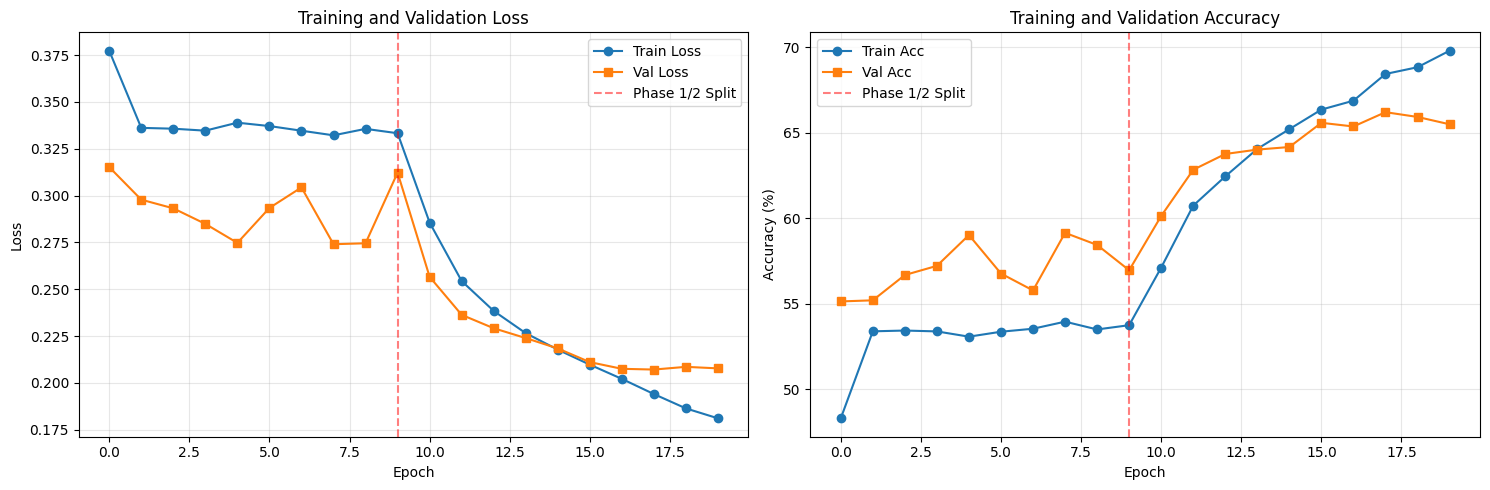

✓ Training history plot saved: vit_training_history.png


In [32]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=NUM_EPOCHS_PHASE1-1, color='r', linestyle='--', alpha=0.5, label='Phase 1/2 Split')
axes[0].legend()

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=NUM_EPOCHS_PHASE1-1, color='r', linestyle='--', alpha=0.5, label='Phase 1/2 Split')
axes[1].legend()

plt.tight_layout()
plt.savefig('vit_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history plot saved: vit_training_history.png")
